# 생성형 AI와 Fault Detection
공정시스템 여름학교 Module C: 공정시스템을 위한 인공지능

Session 2-2: 생성형 AI와 Fault Detection

2025년 8월 21일 (목) 08:30 - 12:30

인천대학교 에너지화학공학과 김종우

In [1]:
!python -m pip install --upgrade pip
!python -m pip install "numpy<2" scipy matplotlib
!python -m pip install casadi==3.6.5
!python -m pip install torch
!python -m pip install scikit-learn

In [2]:
import os
import sys
import time
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import seaborn as sns

KDE 기반 상위 α% UCL 계산 (`compute_KDE`)

입력 데이터(단변량)의 상위 α 백분위수(Upper Control Limit, UCL)를 커널 밀도 추정(KDE)으로 근사해 임계값을 설정

In [3]:
def compute_KDE(df_like, alpha=95):
    """
    Kernel Density Estimation으로 상위 alpha 백분위수(UCL) 계산
    입력은 pandas DataFrame 또는 (N,1) ndarray
    """
    if isinstance(df_like, pd.DataFrame):
        data = df_like.values
    else:
        data = np.asarray(df_like)
    if data.ndim == 1:
        data = data.reshape(-1, 1)

    sigma = np.std(data)
    n = len(data)
    # Silverman's rule
    h = 1.06 * sigma * np.float_power(n, -0.2)
    if not np.isfinite(h) or h <= 0:
        # 분산 0 등 특이 케이스
        h = 1.0
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(data)
    # 충분히 샘플링해서 분위값 근사
    score = kde.sample(100000, random_state=0)
    ucl = np.percentile(score, alpha)
    return float(ucl)

F1 score 계산 (`compute_F1`)

주어진 임계값(UCL) 기준으로 이상 데이터와 정상 데이터를 분류하고, 정밀도(Precision), 재현율(Recall), F1 score를 계산

Confusion matrix

|            | 실제로 normal | 실제로 fault          |
|------------|--------------------------|--------------------|
| Normal로 예측 | TN (True Negative)       | FN (False Negative) |
| Fault로 예측  | FP (False Positive)      | TP (True Positive) |

F1 점수는 Precision과 Recall의 조화평균임

- Precision = TP / (TP + FP): Fault로 예측한 것 중 실제로 fault인 비율
- Recall = TP / (TP + FN): 실제로 fault인 것 중 fault로 예측한 비율
- F1 Score = 2 × (Precision × Recall) / (Precision + Recall)
- [0, 1]의 값. 1일수록 높은 성능의 detector
- Precision과 Recall이 모두 높을 때 높은 값을 가짐
- 한쪽이 낮으면 전체 점수가 크게 떨어져 불균형 탐지를 방지

In [4]:
def compute_F1(fault_data, no_fault_data, UCL):
    """
    fault_data, no_fault_data는 1D array-like
    """
    fault_data = np.asarray(fault_data).ravel()
    no_fault_data = np.asarray(no_fault_data).ravel()

    TP = np.sum(fault_data > UCL)
    FP = np.sum(no_fault_data > UCL)
    FN = len(fault_data) - TP

    Precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    Recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    F1 = 2 * (Precision * Recall) / (Precision + Recall) if (Precision + Recall) > 0 else 0.0
    return int(TP), int(FP), float(F1)

Hotelling's T² 계산

다변량 데이터의 평균 벡터와 공분산 행렬을 이용해 Hotelling's T² 통계량 계산.

관측치 $X$가 평균 $\mu$, 공분산 $S$의 다변량 정규분포를 가진다고 가정하면,
$\alpha$의 유의수준을 갖는 타원형 신뢰구간의 경계는 $T_{\alpha}$로 결정
\begin{equation} T^2_{\alpha} = (X - \mu)^T S^{-1} (X - \mu) \end{equation}

공정 모니터링에서 T2, SPE 점수를 이용하여 fault 여부를 판단

<img src="attachment:5b9318f1-5982-4f63-aaed-246fd06d649e.png" width="300px">

1. 입력: X (N, D) 데이터
2. 평균 벡터 mu (D, )와 공분산 행렬 S (D, D) 계산
3. Cholesky 분해로 S의 역행렬 계산
4. N개의 $T^2 = (X - \mu)^T S^{-1} (X - \mu)$ 계산

In [5]:
def compute_cov_and_inv(X):
    """
    X: (N, D) numpy array
    return: cov S, S^{-1}
    """
    X = np.asarray(X)
    mu = X.mean(axis=0, keepdims=True)
    Xc = X - mu
    # 표본 공분산
    S = (Xc.T @ Xc) / X.shape[0]
    S += 1e-8 * np.eye(S.shape[0])
    # cholesky 분해를 통한 역행렬계산
    L = np.linalg.cholesky(S)
    Linv = np.linalg.inv(L)
    S_inv = Linv.T @ Linv
    return S, S_inv, mu.ravel()

def compute_T2(X, mu, S_inv):
    """
    X: (N, D), mu: (D,), S_inv: (D, D)
    반환: (N,) T²
    """
    Xc = X - mu
    # 벡터화된 T² = diag(Xc @ S^{-1} @ Xc^T)
    # 형태: (N,D) @ (D,D) -> (N,D); elementwise 곱 후 row sum
    XS = Xc @ S_inv
    T2 = np.einsum("nd,nd->n", XS, Xc)
    return T2



Variational Autoencoder (VAE)

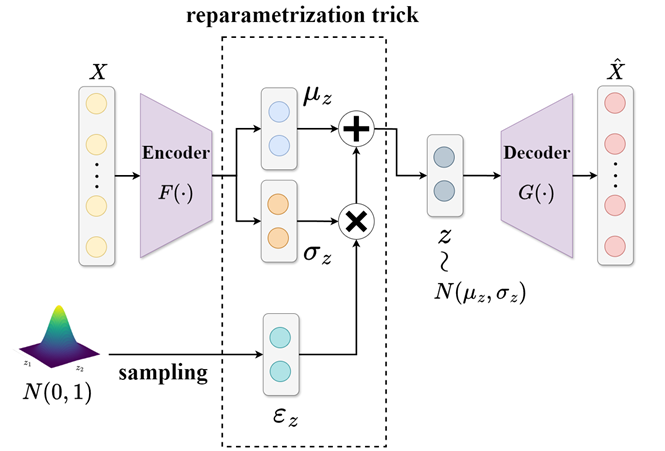

생성형 모델과 공정 모니터링
- 차원 축소
  - PCA, VAE 형태의 생성형 모델은 데이터 차원 축소를 할 수 있음
  - 따라서 고차원 공정 데이터를 처리할 수 있음
  - 고차원 데이터의 상관관계 (분포, 정보)를 보존하면서 데이터의 특성을 파악할 수 있음
  - 수천 차원의 데이터를 3차원 이내로 축소하여 시각화 함으로써 운전자가 이상 유무를 쉽게 판별할 수 있게 해줌
- 부분 공간 분리
  - 관측 공간을 공정의 트렌드와 노이즈를 나타내는 부분공간으로 분리할 수 있음
  - 이상의 원인 변수를 쉽게 규명할 수 있음
  - 이상은 트렌드 혹은 노이즈 둘중 하나에만 영향을 주는 경우가 많음

Variational Autoencoder (VAE)
- Autoencoder (AE)
  - AE는 비지도학습 기법이며, 데이터를 축소한 후 원래의 형태로 재구축하는 구조를 가지고 있다.
  - 비선형 차원축소 기법으로, 선형 차원축소의 PCA의 일반화 형태로 볼 수 있다.
- Variational AE (VAE)
  - AE + 베이지안 추론: AE의 비선형 데이터 차원축소의 기능을 함과 동시에 데이터의 확률분포를 고려할 수 있는 비지도학습 기법
  - 베이지안 추론을 위한 변분 추론 (Variational inference)을 사용
  - VAE를 사용한 이상탐지: Hotelling's T2, Q (or SPE) statistics 사용

뉴럴넷 (`VAE`)
- Encoder: 입력 → 32 → 16 → 잠재 평균(mu), 로그분산(logvar)
- Reparameterization: $z = \mu + \sigma·\varepsilon, \varepsilon \sim \mathcal{N}(0, I)$
- Decoder: 잠재벡터 z → 16 → 32 → 입력 차원 복원

손실 함수 (`vae_loss_mse_kld`)

\begin{equation*}
\begin{split}
L(\theta, \phi; x) &= \underbrace{-\mathbb{E}_{q_{\phi}(z|x)}\left[ \log p_{\theta}(x'|z) \right]}_{\textup{재구축 오차}} + \underbrace{D_{KL}\left( q_{\phi}(z|x) \Vert p(z) \right)}_{\textup{사전 확률 편차}} \\
&= \underbrace{\frac{1}{N} \sum_{i=1}^{N} \|x_i - x'_i\|^2}_{\textup{재구축 오차}} + \underbrace{\dfrac{1}{2}\sum_{j=1}^{m} \left( \sigma_{z_j}^2 + \mu_{z_j}^2  - \ln(\sigma_{z_j}^2) - 1\right)}_{\textup{사전 확률 편차}}
\end{split}
\end{equation*}

- 재구축 오차는 실제 코드에서는 단순히 입력데이터와 출력데이터의 MSE로 구현
- 사전 확률 편차는 Kullback-Leibler (KL) 발산으로 측정하며, 잠재변수 $𝑍$가 사전 잠재 분포 (표준 정규 분포) $𝑝(𝑍)$를 따르도록 유도하는 역할을 한다. $𝑍$ 의 분포가 정규분포를 따르게 되면 Hotelling's T2 통계량을 사용할 수 있게 된다.

(참고) VAE loss 유도
\begin{equation*}
\begin{split}
\ln p_{\theta}(D) &= \mathbb{E}_{q_{\phi}(z|x)}\left[ \ln p_{\theta}(x) \right] \\
&= \mathbb{E}_{q_{\phi}(z|x)}\left[ \ln \dfrac{p_{\theta}(x, z)}{p_{\theta}(z|x)}  \right] \\
&= \mathbb{E}_{q_{\phi}(z|x)}\left[ \ln \dfrac{p_{\theta}(x, z)q_{\phi}(z|x)}{q_{\phi}(z|x)p_{\theta}(z|x)}  \right] \\
&= \mathbb{E}_{q_{\phi}(z|x)}\left[ \ln \dfrac{p_{\theta}(x, z)}{q_{\phi}(z|x)}  \right] +  \mathbb{E}_{q_{\phi}(z|x)}\left[ \ln \dfrac{q_{\phi}(z|x)}{p_{\theta}(z|x)}  \right] \\
&=\underbrace{\mathbb{E}_{q_{\phi}(z|x)}\left[ \ln \dfrac{p_{\theta}(x, z)}{q_{\phi}(z|x)}  \right]}_{\textup{ELBO } \uparrow} +  \underbrace{D_{KL}\left( q_{\phi}(z|x) \Vert p_{\theta}(z|x) \right)}_{\textup{Objective } \downarrow}
\end{split}
\end{equation*}

We aim to minimize the objective by maximizing the ELBO (evidence lower bound).
\begin{equation*}
\begin{split}
\max \underbrace{\mathbb{E}_{q_{\phi}(z|x)}\left[ \ln \dfrac{p_{\theta}(x, z)}{q_{\phi}(z|x)}  \right]}_{\textup{ELBO } \uparrow} &= \int \ln \dfrac{p_{\theta}(x|z)p(z)}{q_{\phi}(z|x)}q_{\phi}(z|x)dz \\
&= \underbrace{\mathbb{E}_{q_{\phi}(z|x)}\left[ p_{\theta}(x|z)\right]}_{\textup{Reconstruction term}} -  \underbrace{D_{KL}\left( q_{\phi}(z|x) \Vert p(z)\right)}_{\textup{Prior fitting term}} \\
\min \mathrm{ELBO} &= -\mathbb{E}_{q_{\phi}(z|x)}\left[ p_{\theta}(x|z)\right] + D_{KL}\left( q_{\phi}(z|x) \Vert p(z)\right)
\end{split}
\end{equation*}

For an normal Gaussian case

\begin{equation*}
\begin{split}
D_{KL}\left( q_{\phi}(z|x) \Vert \mathcal{N}(0, I)\right) = \dfrac{1}{2} \sum_{j=1}^{m} \left( \sigma_{z_j}^2 + \mu_{z_j}^2  - \ln(\sigma_{z_j}^2) - 1\right)
\end{split}
\end{equation*}

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        # Decoder
        self.fc4 = nn.Linear(latent_dim, 16)
        self.fc5 = nn.Linear(16, 32)
        self.fc6 = nn.Linear(32, input_dim)  # linear 출력

    def encode(self, x):
        h = F.leaky_relu(self.fc1(x))
        h = F.leaky_relu(self.fc2(h))
        h = F.leaky_relu(self.fc3(h))
        mu = F.leaky_relu(self.fc_mu(h))
        logvar = F.leaky_relu(self.fc_logvar(h)) # variance를 항상 양수로 만들기 위해 사용
        return mu, logvar

    def reparameterize(self, mu, logvar): # backpropagation을 위해 사용, encode에서 계산된 평균과 분산으로 부터 해당 분포의 샘플링을 해와서 decode에 넣는 과정임임
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z, input_dim):
        h = F.leaky_relu(self.fc4(z))
        h = F.leaky_relu(self.fc5(h))
        out = self.fc6(h)
        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, x.shape[1])
        return recon, mu, logvar, z

def vae_loss_mse_kld(x, recon, mu, logvar, input_dim):
    # 재구축 오차: mean(square)*input_dim
    recon_loss = torch.mean((x - recon) ** 2) * input_dim
    # KL: -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    # 배치당 평균
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar), dim=-1)
    kl = torch.mean(kl)
    return recon_loss + kl, recon_loss.detach(), kl.detach()



조기 종료 (`EarlyStoppingTorch`)

검증 지표(val_loss 등)를 모니터링하여 일정 기간(patience) 동안 개선이 없으면 학습을 중단하고, 가장 좋은 모델 파라미터를 복원
- monitor: 모니터링할 지표명 (기본 "val_loss")
- patience: 개선이 없을 때 허용하는 최대 epoch 수 (기본 20)
- mode: "min"이면 지표가 작아질 때 향상, "max"이면 커질 때 향상

순서
1. step(current, model): 현재 지표와 best 비교
   - 개선 시: best 갱신, wait=0, 모델 상태 저장
   - 개선 없을 시: wait+1, patience 초과 여부 반환
2. restore_best(model): 저장된 best 상태로 모델 복원


In [7]:
class EarlyStoppingTorch:
    def __init__(self, monitor="val_loss", patience=20, mode="min"):
        self.monitor = monitor
        self.patience = patience
        self.mode = mode
        self.best = math.inf if mode == "min" else -math.inf
        self.wait = 0
        self.best_state = None

    def step(self, current, model):
        improved = (current < self.best) if self.mode == "min" else (current > self.best)
        if improved:
            self.best = current
            self.wait = 0
            self.best_state = copy.deepcopy(model.state_dict())
            return False  # not stop
        else:
            self.wait += 1
            return self.wait > self.patience

    def restore_best(self, model):
        if self.best_state is not None:
            model.load_state_dict(self.best_state)



데이터 로드 및 전처리

VAE 학습에 사용할 Tennessee Eastman Process 데이터를 불러오고 표준화를 수행. 그 후 train, test set으로 분할하여 PyTorch DataLoader로 변환

1. CSV 파일 로드 (`train_test.csv`)
2. 표준화: `StandardScaler`로 평균 0, 표준편차 1 스케일 변환
3. Train, test set 분할 (test_size=0.2, shuffle)
4. TensorDataset으로 변환 후 DataLoader 생성 (배치 크기 32)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# 1) 데이터 로드
data_train = pd.read_csv('VAEcodes/data/train_test.csv', index_col=0)
print(data_train.head())

# 2) 표준화
scaler = StandardScaler()
scaler.fit(data_train)
data_train_scaled = scaler.transform(data_train).astype("float32")

# 3) 학습/검증 분리
x_train, x_val = train_test_split(data_train_scaled, test_size=0.2, shuffle=True, random_state=58)
x_total = data_train_scaled

# 4) TensorDataset + DataLoader
bs = 32
train_ds = TensorDataset(torch.from_numpy(x_train))
val_ds   = TensorDataset(torch.from_numpy(x_val))
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds, batch_size=bs, shuffle=False, drop_last=False)


Device: cuda
         0       1       2       3       4       5       6       7       8  \
0  0.24889  3702.3  4502.7  9.4170  26.996  42.183  2705.2  75.173  120.40   
1  0.24904  3666.2  4526.0  9.2682  26.710  42.332  2705.5  74.411  120.41   
2  0.25034  3673.3  4501.3  9.4212  26.842  42.360  2705.3  75.125  120.41   
3  0.25109  3657.8  4497.8  9.3792  26.528  41.982  2707.3  73.992  120.38   
4  0.24563  3698.0  4537.4  9.3746  26.736  42.354  2705.3  75.283  120.42   

         9  ...      42      43      44      45      46      47      48  \
0  0.33611  ...  54.059  24.804  63.269  21.950  40.188  39.461  47.000   
1  0.33676  ...  53.781  24.790  62.171  22.239  40.108  43.710  46.128   
2  0.33739  ...  54.075  24.669  61.585  22.191  40.030  39.480  44.121   
3  0.33664  ...  54.117  24.595  61.561  21.959  40.121  32.848  45.858   
4  0.32521  ...  53.906  24.451  61.388  22.271  39.538  36.682  45.753   

       49      50      51  
0  47.594  41.384  18.905  
1  47.508  

VAE 모델 선언 및 학습

VAE를 정의하고 학습, 검증 루프를 실행하여 최적의 모델 파라미터를 저장

순서
1. VAE 모델 생성 및 Adam 옵티마이저 설정
2. EarlyStoppingTorch로 검증 손실 모니터링
3. run_epoch 함수
   - train 모드: 역전파와 파라미터 업데이트 수행
   - eval 모드: 순전파만 수행, 손실 기록
4. 학습 루프
   - 각 epoch마다 학습/검증 손실 계산
   - 손실 기록(history) 업데이트
   - 조기 종료 조건 확인
5. 학습 종료 후
   - best 모델 파라미터 복원
   - torch.save로 모델과 주요 설정 저장

In [9]:
# ======================
# VAE 모델 선언/학습
# ======================
input_dim = x_train.shape[1]
latent_dim = 8
lr = 1e-3
epochs = 100
patience = 20

vae = VAE(input_dim, latent_dim).to(device)
optim = torch.optim.Adam(vae.parameters(), lr=lr)
stopper = EarlyStoppingTorch(monitor="val_loss", patience=patience, mode="min")

def run_epoch(loader, train_mode=True):
    if train_mode:
        vae.train()
    else:
        vae.eval()
    total_loss, total_n = 0.0, 0
    with torch.set_grad_enabled(train_mode):
        for (xb,) in loader:
            xb = xb.to(device)
            recon, mu, logvar, z = vae(xb)
            loss, _, _ = vae_loss_mse_kld(xb, recon, mu, logvar, input_dim)
            if train_mode:
                optim.zero_grad()
                loss.backward()
                optim.step()
            total_loss += loss.item() * xb.size(0)
            total_n += xb.size(0)
    return total_loss / max(1, total_n)

history = {"train_loss": [], "val_loss": []}
best_path = "VAEcodes/results/VAE_torch.pt"

for epoch in range(1, epochs + 1):
    tr = run_epoch(train_loader, train_mode=True)
    vl = run_epoch(val_loader, train_mode=False)
    history["train_loss"].append(tr)
    history["val_loss"].append(vl)
    print(f"[{epoch:03d}] train={tr:.6f}  val={vl:.6f}")

    if stopper.step(vl, vae):
        print(f"Early stopping triggered at epoch {epoch}.")
        break

stopper.restore_best(vae)
torch.save({
    "model_state": vae.state_dict(),
    "input_dim": input_dim,
    "latent_dim": latent_dim,
    "scaler": scaler  # 필요시 joblib로 따로 저장해도 됨
}, best_path)
print(f"Saved: {best_path}")



[001] train=52.969022  val=52.709614
[002] train=52.461154  val=52.466611
[003] train=52.258945  val=52.323712
[004] train=52.163392  val=52.366163
[005] train=52.143667  val=52.230225
[006] train=52.103017  val=52.269651
[007] train=52.089697  val=52.190108
[008] train=52.063587  val=52.124535
[009] train=52.030509  val=52.093360
[010] train=51.977157  val=52.160831
[011] train=51.965329  val=52.025501
[012] train=51.871884  val=52.114038
[013] train=51.487262  val=51.412015
[014] train=50.754830  val=51.098248
[015] train=50.002786  val=49.656962
[016] train=49.032193  val=49.972587
[017] train=48.842917  val=49.324691
[018] train=48.796102  val=49.241991
[019] train=48.544591  val=49.211625
[020] train=48.458774  val=49.025379
[021] train=48.384473  val=48.640330
[022] train=48.215111  val=48.894208
[023] train=47.923303  val=48.163482
[024] train=47.879741  val=48.681250
[025] train=47.912741  val=48.359500
[026] train=47.982215  val=47.885736
[027] train=48.056477  val=47.484999
[

잠재공간 추출 및 시각화

학습된 VAE의 인코더를 통해 전체 데이터의 잠재벡터를 추출하고, 변수 간 관계를 시각화하여 분포 및 상관 구조를 파악

순서
1. VAE를 평가 모드로 전환 (`vae.eval()`)
2. 전체 데이터 `x_total`을 텐서로 변환 후 모델에 입력
3. 출력 중 잠재변수 z만 추출해 CPU로 이동 및 numpy 배열 변환
4. 잠재변수를 DataFrame으로 변환
5. seaborn `pairplot`으로 잠재변수 간 산점도/분포 시각화

<Figure size 2000x2000 with 0 Axes>

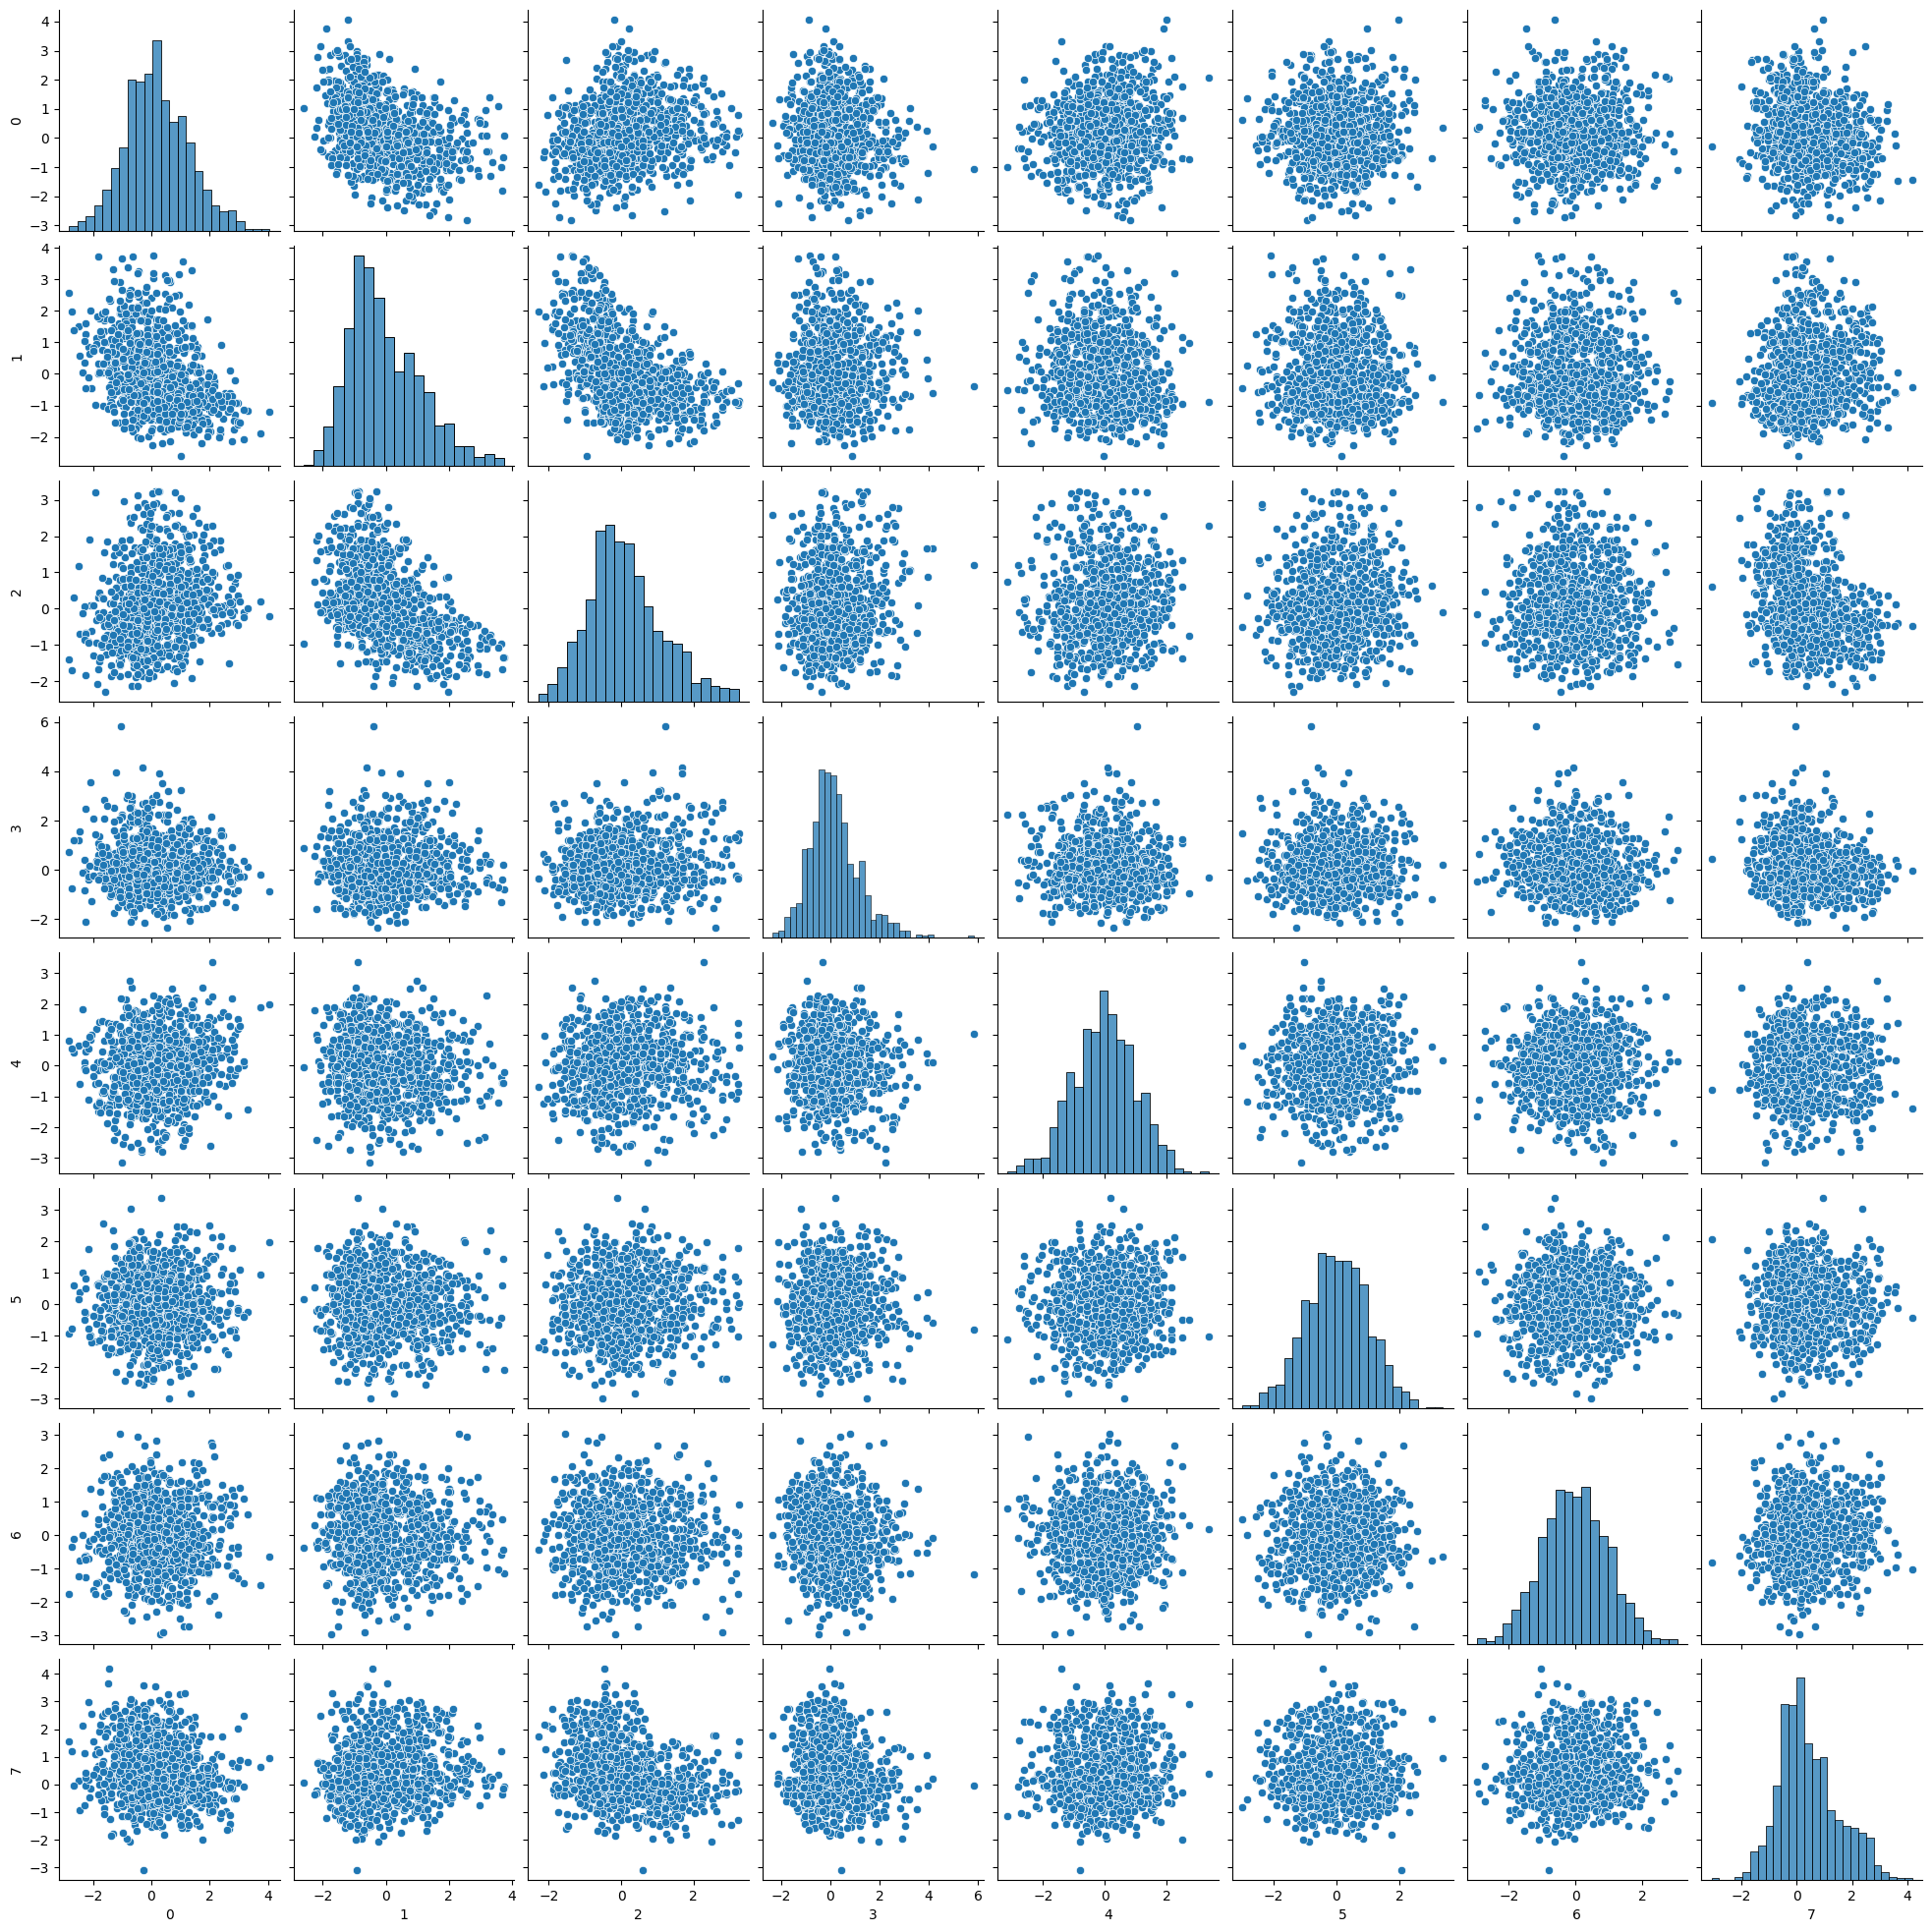

In [ ]:
vae.eval() # 대각행렬이 가우시안 분포를 잘 따르고 다른 변수와도 원형 분산 plot이 나옴 -> 정규화된 분포를 잘 따른다른다
with torch.no_grad():
    X_total_t = torch.from_numpy(x_total).to(device)
    _, _, _, Z_total_t = vae(X_total_t)
    Z_total = Z_total_t.cpu().numpy()

latent_df = pd.DataFrame(Z_total)
plt.figure(figsize=(20, 20))
sns.pairplot(latent_df)
plt.show()

SPE 및 Hotelling's T2 임계값(UCL) 계산 및 시각화

학습 데이터에서 Squared Prediction Error(SPE)와 Hotelling's T2 값을 계산하고, KDE 기반 상위 95% 임계값(UCL)을 산출하여 기준선으로 시각화한다.

순서
1. SPE 계산
   - 전체 데이터 재구성 후 (입력 - 재구성)의 제곱합을 샘플별로 계산
   - `compute_KDE`로 SPE의 95% UCL 계산
   - 시계열로 plot 후 UCL 표시
2. Hotelling's T² 계산
   - 잠재변수 Z의 평균, 공분산 역행렬 계산
   - `compute_T2`로 각 샘플의 T2 산출
   - `compute_KDE`로 T2의 95% UCL 계산
   - 시계열로 plot 후 UCL 표시

SPE UCL: 60.195721954370946


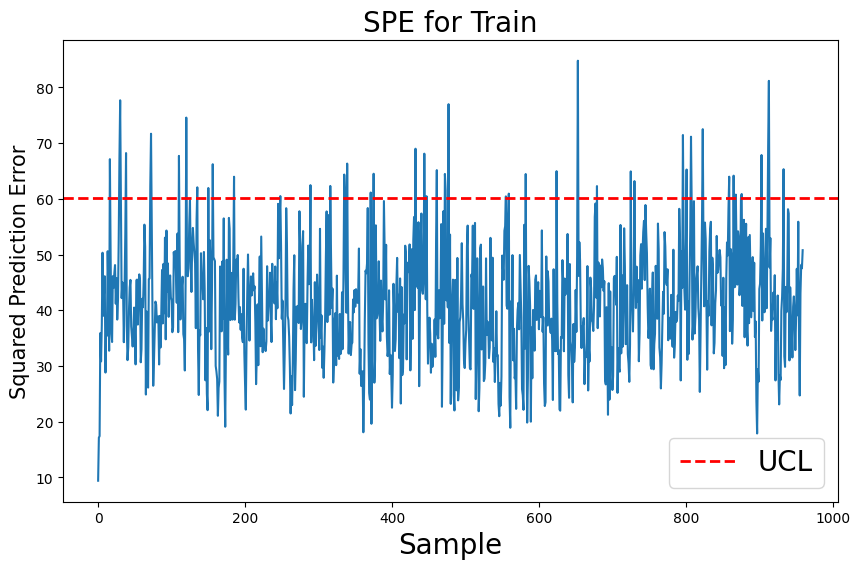

T2 UCL: 15.718387335484566


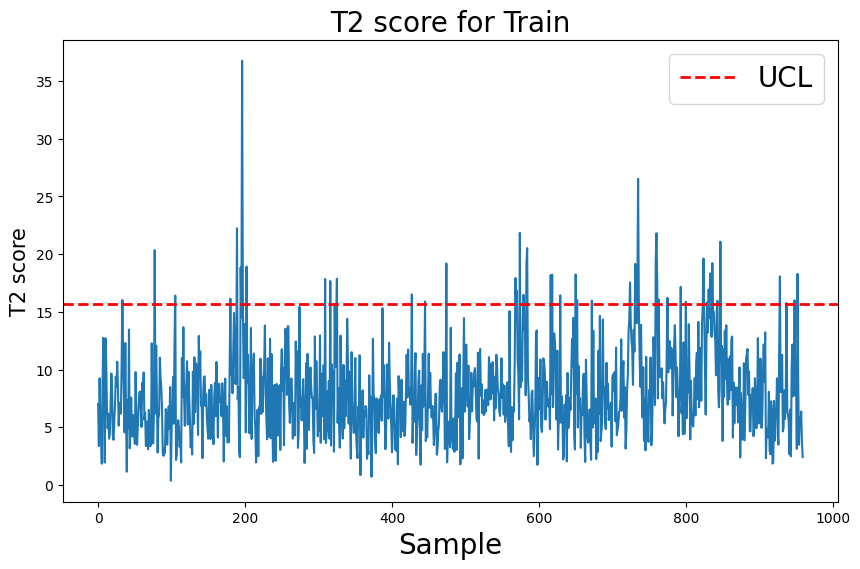

In [11]:
# SPE UCL
with torch.no_grad():
    recon_total, _, _, _ = vae(torch.from_numpy(x_total).to(device))
    recon_total = recon_total.cpu().numpy()
total_recon = np.sum((x_total - recon_total) ** 2, axis=1)  # squared prediction error
UCL_SPE = compute_KDE(total_recon.reshape(-1, 1), alpha=95)
print(f"SPE UCL: {UCL_SPE}")

plt.figure(figsize=(10, 6))
plt.plot(total_recon)
plt.axhline(y=UCL_SPE, color='r', linestyle='--', label='UCL', linewidth=2)
plt.xlabel('Sample', fontsize=20)
plt.ylabel('Squared Prediction Error', fontsize=15)
plt.title('SPE for Train', fontsize=20)
plt.legend(fontsize=20)
plt.savefig('VAEcodes/results/SPE for Train.png')
plt.show()

# Hotelling T² UCL
S, S_inv, mu = compute_cov_and_inv(Z_total)
T2_total = compute_T2(Z_total, mu, S_inv)
UCL_T2 = compute_KDE(T2_total.reshape(-1, 1), alpha=95)
print(f"T2 UCL: {UCL_T2}")

plt.figure(figsize=(10, 6))
plt.plot(T2_total)
plt.axhline(y=UCL_T2, color='r', linestyle='--', label='UCL', linewidth=2)
plt.xlabel('Sample', fontsize=20)
plt.ylabel('T2 score', fontsize=15)
plt.title('T2 score for Train', fontsize=20)
plt.legend(fontsize=20)
plt.savefig('VAEcodes/results/T2 score for Train.png')
plt.show()

Fault detection 성능 평가

학습된 VAE 모델과 UCL을 사용하여 각 Fault 시나리오(1~21)의 SPE 및 T2 기반 fault detection 성능 평가

순서
1. 각 Fault 테스트 데이터 불러오기 및 표준화
2. VAE로 재구성 및 잠재변수 추출
3. SPE와 T2 값을 계산
4. Fault 발생하는 160번째 sample 전후 구간 분리
5. `compute_F1`로 TP, FP, F1 score 계산
6. Fault별 SPE, T2 시계열 그래프 생성 및 저장

In [ ]:
result = pd.DataFrame(columns=['Fault', 'FDR_SPE', 'FAR_SPE', 'F1_Score_SPE',
                               'FDR_T2',  'FAR_T2',  'F1_Score_T2'])

for i in range(1, 22):
    fn = f'VAEcodes/data/fault_{i}_test.csv'
    if not os.path.isfile(fn):
        print(f"Warning: Cannot find {fn} file")
        continue
    fault = pd.read_csv(fn, index_col=0).values.astype('float32')
    fault = scaler.transform(fault).astype('float32')

    with torch.no_grad():
        Xf = torch.from_numpy(fault).to(device)
        recon_f, _, _, Zf_t = vae(Xf)
        recon_f = recon_f.cpu().numpy()
        Zf = Zf_t.cpu().numpy()

    fault_SPE = np.sum((fault - recon_f) ** 2, axis=1)
    fault_T2  = compute_T2(Zf, mu, S_inv)

    # fault는 160번째 샘플부터 발생
    no_fault_SPE = fault_SPE[:160]
    yes_fault_SPE = fault_SPE[160:]

    no_fault_T2 = fault_T2[:160]
    yes_fault_T2 = fault_T2[160:]

    TP_SPE, FP_SPE, F1_SPE = compute_F1(yes_fault_SPE, no_fault_SPE, UCL_SPE)
    TP_T2,  FP_T2,  F1_T2  = compute_F1(yes_fault_T2,  no_fault_T2,  UCL_T2)

    result.loc[len(result)] = [i, TP_SPE, FP_SPE, F1_SPE, TP_T2, FP_T2, F1_T2]

    # Plot
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))
    axs[0].plot(fault_SPE, label='SPE')
    axs[0].axhline(y=UCL_SPE, color='r', linestyle='--', label='UCL', linewidth=2)
    axs[0].set_xlabel('Sample', fontsize=15)
    axs[0].set_ylabel('SPE', fontsize=15)
    axs[0].set_title(f'Fault {i} SPE', fontsize=20)
    axs[0].legend(fontsize=15)

    axs[1].plot(fault_T2, label='T2')
    axs[1].axhline(y=UCL_T2, color='r', linestyle='--', label='UCL', linewidth=2)
    axs[1].set_xlabel('Sample', fontsize=15)
    axs[1].set_ylabel('T2 Score', fontsize=15)
    axs[1].set_title(f'Fault {i} T2', fontsize=20)
    axs[1].legend(fontsize=15)

    plt.tight_layout()
    plt.savefig(f'VAEcodes/results/Fault{i}_SPE_T2.png')
    plt.close()

result.to_csv('VAEcodes/results/result.csv', index=False)
print("Saved: result.csv")

/home/sjbaek/miniforge3/envs/PSE_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/sjbaek/miniforge3/envs/PSE_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/sjbaek/miniforge3/envs/PSE_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/sjbaek/miniforge3/envs/PSE_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/sjbaek/miniforge3/envs/PSE_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid f

Saved: result.csv
